In [1]:
# Required imports
import os
import sys
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, Dataset
from torchvision import datasets, transforms, models
from torchvision.models.mobilenetv2 import InvertedResidual
from torchvision.models import MobileNet_V2_Weights
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import matplotlib
matplotlib.use('Agg')  # non-GUI backend

# Import CBAM
sys.path.append('../models')
from cbam import CBAM

# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transforms
weights = MobileNet_V2_Weights.DEFAULT
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    weights.transforms()
])
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    weights.transforms()
])

# Load dataset
full_train_dataset = datasets.ImageFolder('../../dataset_split/train', transform=train_transforms)
full_val_dataset = datasets.ImageFolder('../../dataset_split/val', transform=val_transforms)

# Select classes
selected_classes = ['Tomato___Late_blight', 'Potato___Early_blight']
selected_class_indices = [full_train_dataset.class_to_idx[cls] for cls in selected_classes]
index_mapping = {orig_idx: new_idx for new_idx, orig_idx in enumerate(selected_class_indices)}

class ReindexedSubset(Dataset):
    def __init__(self, subset, class_indices_mapping):
        self.subset = subset
        self.mapping = class_indices_mapping

    def __getitem__(self, index):
        x, y = self.subset[index]
        y = self.mapping[y]
        return x, y

    def __len__(self):
        return len(self.subset)

def filter_and_remap(dataset, class_indices, mapping):
    indices = [i for i, (_, label) in enumerate(dataset) if label in class_indices]
    subset = Subset(dataset, indices)
    return ReindexedSubset(subset, mapping)

train_dataset = filter_and_remap(full_train_dataset, selected_class_indices, index_mapping)
val_dataset = filter_and_remap(full_val_dataset, selected_class_indices, index_mapping)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define model
class MobileNetV2_CBAM(nn.Module):
    def __init__(self, base_model, num_classes):
        super(MobileNetV2_CBAM, self).__init__()
        self.features = nn.Sequential()
        for name, module in base_model.features._modules.items():
            self.features.add_module(name, module)
            if isinstance(module, InvertedResidual):
                conv_layers = [layer for layer in module.conv if isinstance(layer, nn.Conv2d)]
                out_channels = conv_layers[-1].out_channels if conv_layers else base_model.last_channel
                self.features.add_module(f"cbam_{name}", CBAM(out_channels))
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(base_model.last_channel, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

base_model = models.mobilenet_v2(weights=weights)
model = MobileNetV2_CBAM(base_model, len(selected_classes)).to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

# Train
NUM_EPOCHS = 100
for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()

    scheduler.step()
    acc = correct / total
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {running_loss:.4f}, Accuracy: {acc:.4f}")

# Save model
torch.save(model.state_dict(), "mobilenet_v2_cbam.pth")

# Evaluate
model.eval()
all_labels, all_preds, all_features = [], [], []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        features = model.features(images).mean(dim=[2, 3])  # global avg pool features
        _, predicted = torch.max(outputs, 1)
        all_features.append(features.cpu())
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Reports
print(classification_report(all_labels, all_preds, target_names=selected_classes))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, cmap="Blues", xticklabels=selected_classes, yticklabels=selected_classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("confMatrix.png")

f1 = f1_score(all_labels, all_preds, average='weighted')
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
print(f"F1 Score: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")

# Single image prediction example
images, labels = next(iter(val_loader))
input_tensor = images[0].unsqueeze(0).to(device)
true_label = labels[0].item()

with torch.no_grad():
    outputs = model(input_tensor)
    _, predicted = torch.max(outputs, 1)
    pred_label = predicted.item()

image_np = images[0].permute(1, 2, 0).cpu().numpy()
image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
image_np = np.clip(image_np, 0, 1)
plt.imshow(image_np)
plt.title(f"True: {selected_classes[true_label]} | Predicted: {selected_classes[pred_label]}")
plt.axis('off')
plt.savefig("test_output.png")

# Grad-CAM (simplified version)
def apply_gradcam(model, input_tensor):
    model.eval()
    gradients = []

    def save_gradient(grad):
        gradients.append(grad)

    # Choose last CBAM layer
    for name, module in model.features.named_children():
        if 'cbam' in name:
            target_layer = module

    def forward_hook(module, input, output):
        output.register_hook(save_gradient)
        return output

    handle = target_layer.register_forward_hook(forward_hook)
    output = model(input_tensor)
    pred_class = output.argmax().item()
    model.zero_grad()
    class_loss = output[0, pred_class]
    class_loss.backward()
    handle.remove()

    gradient = gradients[0][0].cpu().numpy()
    activation = target_layer(input_tensor).detach()[0].cpu().numpy()
    weights = np.mean(gradient, axis=(1, 2))
    cam = np.sum(weights[:, None, None] * activation, axis=0)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = plt.cm.jet(cam)[..., :3]

    orig_image = input_tensor[0].cpu().permute(1, 2, 0).numpy()
    orig_image = orig_image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    orig_image = np.clip(orig_image, 0, 1)
    overlay = 0.5 * cam + 0.5 * orig_image
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.savefig("gradcam_cbam_layer.png")

apply_gradcam(model, input_tensor)

# t-SNE Visualization
all_features = torch.cat(all_features, dim=0).numpy()
tsne = TSNE(n_components=2, perplexity=30, n_iter=3000, random_state=42)
features_2d = tsne.fit_transform(all_features)

plt.figure(figsize=(8,6))
for i, label in enumerate(np.unique(all_labels)):
    indices = np.where(np.array(all_labels) == label)
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], label=selected_classes[label], alpha=0.6)
plt.legend()
plt.title("t-SNE Visualization")
plt.savefig("tsne_plot.png")


Epoch 1/100: 100%|██████████| 91/91 [02:02<00:00,  1.35s/it]


Epoch [1/100], Loss: 49.1891, Accuracy: 0.6639


Epoch 2/100: 100%|██████████| 91/91 [02:05<00:00,  1.38s/it]


Epoch [2/100], Loss: 32.1310, Accuracy: 0.8446


Epoch 3/100: 100%|██████████| 91/91 [02:04<00:00,  1.36s/it]


Epoch [3/100], Loss: 21.8737, Accuracy: 0.9022


Epoch 4/100: 100%|██████████| 91/91 [02:05<00:00,  1.38s/it]


Epoch [4/100], Loss: 18.3396, Accuracy: 0.9188


Epoch 5/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [5/100], Loss: 16.6598, Accuracy: 0.9220


Epoch 6/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [6/100], Loss: 17.1458, Accuracy: 0.9181


Epoch 7/100: 100%|██████████| 91/91 [02:04<00:00,  1.36s/it]


Epoch [7/100], Loss: 16.0910, Accuracy: 0.9258


Epoch 8/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [8/100], Loss: 16.2384, Accuracy: 0.9247


Epoch 9/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [9/100], Loss: 18.5787, Accuracy: 0.9136


Epoch 10/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [10/100], Loss: 16.4841, Accuracy: 0.9272


Epoch 11/100: 100%|██████████| 91/91 [02:01<00:00,  1.33s/it]


Epoch [11/100], Loss: 17.6118, Accuracy: 0.9247


Epoch 12/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [12/100], Loss: 17.1253, Accuracy: 0.9230


Epoch 13/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [13/100], Loss: 16.3505, Accuracy: 0.9292


Epoch 14/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [14/100], Loss: 17.2435, Accuracy: 0.9220


Epoch 15/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [15/100], Loss: 16.4229, Accuracy: 0.9247


Epoch 16/100: 100%|██████████| 91/91 [02:02<00:00,  1.35s/it]


Epoch [16/100], Loss: 17.3446, Accuracy: 0.9275


Epoch 17/100: 100%|██████████| 91/91 [02:02<00:00,  1.35s/it]


Epoch [17/100], Loss: 16.9386, Accuracy: 0.9244


Epoch 18/100: 100%|██████████| 91/91 [02:02<00:00,  1.35s/it]


Epoch [18/100], Loss: 17.0628, Accuracy: 0.9213


Epoch 19/100: 100%|██████████| 91/91 [02:05<00:00,  1.38s/it]


Epoch [19/100], Loss: 17.7486, Accuracy: 0.9181


Epoch 20/100: 100%|██████████| 91/91 [02:02<00:00,  1.35s/it]


Epoch [20/100], Loss: 18.0980, Accuracy: 0.9213


Epoch 21/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [21/100], Loss: 17.0926, Accuracy: 0.9216


Epoch 22/100: 100%|██████████| 91/91 [02:08<00:00,  1.42s/it]


Epoch [22/100], Loss: 15.7254, Accuracy: 0.9251


Epoch 23/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [23/100], Loss: 16.7060, Accuracy: 0.9251


Epoch 24/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [24/100], Loss: 17.0105, Accuracy: 0.9244


Epoch 25/100: 100%|██████████| 91/91 [02:02<00:00,  1.34s/it]


Epoch [25/100], Loss: 17.5836, Accuracy: 0.9251


Epoch 26/100: 100%|██████████| 91/91 [02:03<00:00,  1.35s/it]


Epoch [26/100], Loss: 16.2159, Accuracy: 0.9282


Epoch 27/100: 100%|██████████| 91/91 [02:02<00:00,  1.34s/it]


Epoch [27/100], Loss: 16.3490, Accuracy: 0.9261


Epoch 28/100: 100%|██████████| 91/91 [02:01<00:00,  1.34s/it]


Epoch [28/100], Loss: 17.4296, Accuracy: 0.9209


Epoch 29/100: 100%|██████████| 91/91 [02:05<00:00,  1.38s/it]


Epoch [29/100], Loss: 16.4199, Accuracy: 0.9261


Epoch 30/100: 100%|██████████| 91/91 [02:05<00:00,  1.38s/it]


Epoch [30/100], Loss: 15.9342, Accuracy: 0.9268


Epoch 31/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [31/100], Loss: 17.7899, Accuracy: 0.9213


Epoch 32/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [32/100], Loss: 18.0347, Accuracy: 0.9254


Epoch 33/100: 100%|██████████| 91/91 [02:05<00:00,  1.38s/it]


Epoch [33/100], Loss: 16.1823, Accuracy: 0.9233


Epoch 34/100: 100%|██████████| 91/91 [02:04<00:00,  1.36s/it]


Epoch [34/100], Loss: 15.4869, Accuracy: 0.9341


Epoch 35/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [35/100], Loss: 17.3603, Accuracy: 0.9223


Epoch 36/100: 100%|██████████| 91/91 [02:06<00:00,  1.39s/it]


Epoch [36/100], Loss: 16.2495, Accuracy: 0.9254


Epoch 37/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [37/100], Loss: 16.8304, Accuracy: 0.9216


Epoch 38/100: 100%|██████████| 91/91 [02:05<00:00,  1.38s/it]


Epoch [38/100], Loss: 17.0418, Accuracy: 0.9206


Epoch 39/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [39/100], Loss: 17.0668, Accuracy: 0.9206


Epoch 40/100: 100%|██████████| 91/91 [02:01<00:00,  1.33s/it]


Epoch [40/100], Loss: 16.6699, Accuracy: 0.9237


Epoch 41/100: 100%|██████████| 91/91 [02:01<00:00,  1.33s/it]


Epoch [41/100], Loss: 17.2044, Accuracy: 0.9244


Epoch 42/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [42/100], Loss: 16.6725, Accuracy: 0.9265


Epoch 43/100: 100%|██████████| 91/91 [02:06<00:00,  1.39s/it]


Epoch [43/100], Loss: 16.3600, Accuracy: 0.9247


Epoch 44/100: 100%|██████████| 91/91 [02:04<00:00,  1.36s/it]


Epoch [44/100], Loss: 16.1930, Accuracy: 0.9265


Epoch 45/100: 100%|██████████| 91/91 [02:02<00:00,  1.35s/it]


Epoch [45/100], Loss: 18.8010, Accuracy: 0.9233


Epoch 46/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [46/100], Loss: 16.7422, Accuracy: 0.9202


Epoch 47/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [47/100], Loss: 17.1579, Accuracy: 0.9223


Epoch 48/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [48/100], Loss: 15.6257, Accuracy: 0.9310


Epoch 49/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [49/100], Loss: 16.1749, Accuracy: 0.9244


Epoch 50/100: 100%|██████████| 91/91 [02:02<00:00,  1.35s/it]


Epoch [50/100], Loss: 16.8473, Accuracy: 0.9296


Epoch 51/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [51/100], Loss: 15.6495, Accuracy: 0.9282


Epoch 52/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [52/100], Loss: 17.2361, Accuracy: 0.9188


Epoch 53/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [53/100], Loss: 15.7040, Accuracy: 0.9303


Epoch 54/100: 100%|██████████| 91/91 [02:02<00:00,  1.34s/it]


Epoch [54/100], Loss: 15.9560, Accuracy: 0.9258


Epoch 55/100: 100%|██████████| 91/91 [02:05<00:00,  1.38s/it]


Epoch [55/100], Loss: 15.9462, Accuracy: 0.9247


Epoch 56/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [56/100], Loss: 17.7386, Accuracy: 0.9261


Epoch 57/100: 100%|██████████| 91/91 [02:05<00:00,  1.38s/it]


Epoch [57/100], Loss: 17.1360, Accuracy: 0.9258


Epoch 58/100: 100%|██████████| 91/91 [02:02<00:00,  1.34s/it]


Epoch [58/100], Loss: 17.6692, Accuracy: 0.9188


Epoch 59/100: 100%|██████████| 91/91 [02:04<00:00,  1.36s/it]


Epoch [59/100], Loss: 15.9580, Accuracy: 0.9254


Epoch 60/100: 100%|██████████| 91/91 [02:02<00:00,  1.35s/it]


Epoch [60/100], Loss: 17.0103, Accuracy: 0.9230


Epoch 61/100: 100%|██████████| 91/91 [02:05<00:00,  1.37s/it]


Epoch [61/100], Loss: 16.2086, Accuracy: 0.9237


Epoch 62/100: 100%|██████████| 91/91 [02:05<00:00,  1.38s/it]


Epoch [62/100], Loss: 16.7897, Accuracy: 0.9240


Epoch 63/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [63/100], Loss: 16.7568, Accuracy: 0.9265


Epoch 64/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [64/100], Loss: 18.2892, Accuracy: 0.9181


Epoch 65/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [65/100], Loss: 16.1817, Accuracy: 0.9258


Epoch 66/100: 100%|██████████| 91/91 [02:04<00:00,  1.36s/it]


Epoch [66/100], Loss: 16.2342, Accuracy: 0.9261


Epoch 67/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [67/100], Loss: 20.6222, Accuracy: 0.9230


Epoch 68/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [68/100], Loss: 18.4751, Accuracy: 0.9258


Epoch 69/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [69/100], Loss: 17.5260, Accuracy: 0.9244


Epoch 70/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [70/100], Loss: 16.4559, Accuracy: 0.9240


Epoch 71/100: 100%|██████████| 91/91 [02:03<00:00,  1.35s/it]


Epoch [71/100], Loss: 16.6064, Accuracy: 0.9296


Epoch 72/100: 100%|██████████| 91/91 [02:06<00:00,  1.39s/it]


Epoch [72/100], Loss: 16.4303, Accuracy: 0.9299


Epoch 73/100: 100%|██████████| 91/91 [02:05<00:00,  1.38s/it]


Epoch [73/100], Loss: 17.0441, Accuracy: 0.9324


Epoch 74/100: 100%|██████████| 91/91 [02:06<00:00,  1.39s/it]


Epoch [74/100], Loss: 16.2123, Accuracy: 0.9306


Epoch 75/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [75/100], Loss: 17.0605, Accuracy: 0.9244


Epoch 76/100: 100%|██████████| 91/91 [02:05<00:00,  1.38s/it]


Epoch [76/100], Loss: 15.9984, Accuracy: 0.9313


Epoch 77/100: 100%|██████████| 91/91 [02:02<00:00,  1.34s/it]


Epoch [77/100], Loss: 16.9372, Accuracy: 0.9279


Epoch 78/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [78/100], Loss: 15.8313, Accuracy: 0.9310


Epoch 79/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [79/100], Loss: 16.7845, Accuracy: 0.9202


Epoch 80/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [80/100], Loss: 16.4912, Accuracy: 0.9251


Epoch 81/100: 100%|██████████| 91/91 [02:02<00:00,  1.34s/it]


Epoch [81/100], Loss: 16.3039, Accuracy: 0.9306


Epoch 82/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [82/100], Loss: 16.5507, Accuracy: 0.9254


Epoch 83/100: 100%|██████████| 91/91 [02:06<00:00,  1.39s/it]


Epoch [83/100], Loss: 16.9653, Accuracy: 0.9272


Epoch 84/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [84/100], Loss: 16.6100, Accuracy: 0.9230


Epoch 85/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [85/100], Loss: 17.0303, Accuracy: 0.9247


Epoch 86/100: 100%|██████████| 91/91 [02:02<00:00,  1.35s/it]


Epoch [86/100], Loss: 16.1908, Accuracy: 0.9251


Epoch 87/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [87/100], Loss: 15.8314, Accuracy: 0.9292


Epoch 88/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [88/100], Loss: 17.7417, Accuracy: 0.9192


Epoch 89/100: 100%|██████████| 91/91 [02:02<00:00,  1.35s/it]


Epoch [89/100], Loss: 17.9499, Accuracy: 0.9185


Epoch 90/100: 100%|██████████| 91/91 [02:04<00:00,  1.36s/it]


Epoch [90/100], Loss: 16.4311, Accuracy: 0.9299


Epoch 91/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [91/100], Loss: 16.1467, Accuracy: 0.9327


Epoch 92/100: 100%|██████████| 91/91 [02:02<00:00,  1.35s/it]


Epoch [92/100], Loss: 16.6633, Accuracy: 0.9254


Epoch 93/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [93/100], Loss: 16.0495, Accuracy: 0.9313


Epoch 94/100: 100%|██████████| 91/91 [02:05<00:00,  1.38s/it]


Epoch [94/100], Loss: 16.8279, Accuracy: 0.9230


Epoch 95/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [95/100], Loss: 17.3813, Accuracy: 0.9168


Epoch 96/100: 100%|██████████| 91/91 [02:00<00:00,  1.32s/it]


Epoch [96/100], Loss: 16.6401, Accuracy: 0.9251


Epoch 97/100: 100%|██████████| 91/91 [02:03<00:00,  1.35s/it]


Epoch [97/100], Loss: 17.1061, Accuracy: 0.9268


Epoch 98/100: 100%|██████████| 91/91 [02:04<00:00,  1.37s/it]


Epoch [98/100], Loss: 17.3717, Accuracy: 0.9233


Epoch 99/100: 100%|██████████| 91/91 [02:02<00:00,  1.35s/it]


Epoch [99/100], Loss: 17.2251, Accuracy: 0.9244


Epoch 100/100: 100%|██████████| 91/91 [02:03<00:00,  1.36s/it]


Epoch [100/100], Loss: 16.3753, Accuracy: 0.9306
                       precision    recall  f1-score   support

 Tomato___Late_blight       0.97      0.93      0.95       940
Potato___Early_blight       0.87      0.94      0.90       494

             accuracy                           0.93      1434
            macro avg       0.92      0.93      0.92      1434
         weighted avg       0.93      0.93      0.93      1434

F1 Score: 0.9302 | Precision: 0.9322 | Recall: 0.9296


RuntimeError: Given groups=1, weight of size [20, 320, 1, 1], expected input[1, 3, 1, 1] to have 320 channels, but got 3 channels instead

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt


In [14]:
def apply_gradcam(model, input_tensor):
    model.eval()
    gradients = []
    activations = []

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    def forward_hook(module, input, output):
        activations.append(output)

    target_layer = model.features[-1]  # or your CBAM layer
    handle_fw = target_layer.register_forward_hook(forward_hook)
    handle_bw = target_layer.register_full_backward_hook(backward_hook)

    output = model(input_tensor)
    class_idx = output.argmax(dim=1).item()

    model.zero_grad()
    output[0, class_idx].backward()

    gradient = gradients[0][0].cpu().numpy()
    activation = activations[0][0].cpu().numpy()

    weights = np.mean(gradient, axis=(1, 2))
    cam = np.sum(weights[:, None, None] * activation, axis=0)
    cam = np.maximum(cam, 0)
    cam = cam / cam.max()
    cam = cv2.resize(cam, (input_tensor.shape[2], input_tensor.shape[3]))

    # Visualization inside
    plt.figure(figsize=(5, 5))
    plt.imshow(cam, cmap='jet', alpha=0.5)
    plt.title("Grad-CAM")
    plt.axis('off')
    plt.savefig("test_output.png")
    plt.show()

    handle_fw.remove()
    handle_bw.remove()


/home/itartoussi/miniconda3/envs/agml_env_312/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


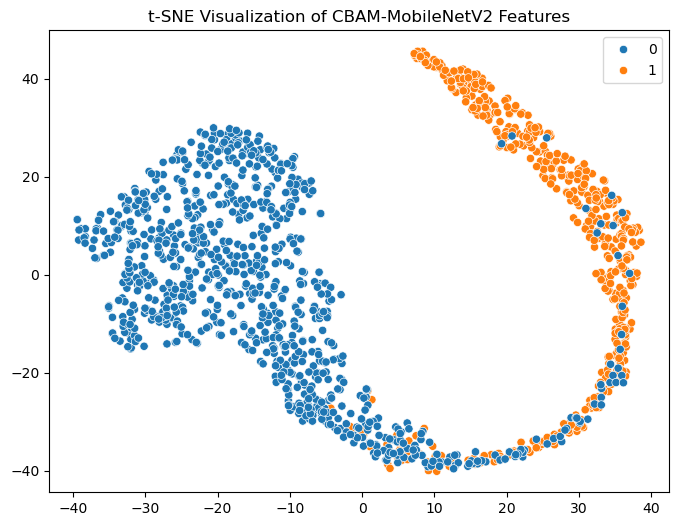

In [12]:
features_list = []
labels_list = []

def hook_fn(module, input, output):
    features_list.append(output.detach().cpu())

handle = model.features[-1].register_forward_hook(hook_fn)  # or use the correct CBAM layer

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        _ = model(inputs)
        labels_list.append(labels.cpu())

handle.remove()

# Concatenate
# Concatenate features and labels
features_tensor = torch.cat(features_list, dim=0)  # shape: (N, C, H, W)
labels_tensor = torch.cat(labels_list, dim=0)      # shape: (N,)

# Flatten each feature map into a 1D vector (e.g., via global avg pooling)
features_flat = torch.nn.functional.adaptive_avg_pool2d(features_tensor, 1)  # shape: (N, C, 1, 1)
features_flat = features_flat.view(features_flat.size(0), -1)  # shape: (N, C)

# Convert to NumPy
features_np = features_flat.numpy()
labels_np = labels_tensor.numpy()


# Run t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
tsne_result = tsne.fit_transform(features_np)

# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=labels_np, palette="tab10", legend='full')
plt.title("t-SNE Visualization of CBAM-MobileNetV2 Features")
plt.savefig("tsne_cbam_features.png")
plt.show()
